In [1]:
import os

# data_dir = './Garbage classification/Garbage classification'
data_dir  = '/kaggle/input/garbage-classification/Garbage classification/Garbage classification'

classes = os.listdir(data_dir)
print(classes)

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


In [2]:
from torchvision.datasets import ImageFolder  # ImageFolder 类是用于加载具有类别标签的图像数据集的便捷工具
import torchvision.transforms as transforms  # transforms 模块包含用于图像预处理的各种转换操作

# 大小调整为256x256像素，并且转换为Pytorch张量
transformations = transforms.Compose([transforms.Resize((256, 256)),transforms.RandomRotation(5), transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

dataset = ImageFolder(data_dir, transform=transformations)
dataset

Dataset ImageFolder
    Number of datapoints: 2527
    Root location: /kaggle/input/garbage-classification/Garbage classification/Garbage classification
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
               RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [3]:
import torch

random_seed = 42
torch.manual_seed(random_seed)  # 将随机数生成器的种子设置为指定的值 可复现
torch.cuda.manual_seed(random_seed)  # 在GPU也这么设置

In [4]:
from torch.utils.data import random_split

# split_sizes = [1593, 176, 758]
split_sizes = [1600, 200, 727]
train_ds, val_ds, test_ds = random_split(dataset, split_sizes)
print("训练集、验证集和测试集大小:")
len(train_ds), len(val_ds), len(test_ds)

训练集、验证集和测试集大小:


(1600, 200, 727)

In [5]:
from torch.utils.data.dataloader import DataLoader

# 定义批量大小
batch_size = 64

# 创建训练集 DataLoader
# shuffle=True 表示在每个 epoch 开始时对数据进行洗牌 就是打乱的意思
# num_workers 表示用于数据加载的子进程数量
# pin_memory=True 可以将数据加载到 CUDA 固定内存中，提高数据传输速度
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

# 创建验证集 DataLoader
# batch_size*2 验证集的批量大小是训练集的两倍
val_dl = DataLoader(val_ds, batch_size * 2, num_workers=4, pin_memory=True)

In [6]:
import torch
import torch.nn.functional as f
import torch.nn as nn


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(torch.Tensor(preds == labels)).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # 生成预测
        loss = f.cross_entropy(out, labels)  # 计算损失
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # 生成预测
        loss = f.cross_entropy(out, labels)  # 计算损失
        acc = accuracy(out, labels)  # 计算准确率
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        # 将损失列表转换为张量并计算均值
        batch_losses = torch.stack([x['val_loss'] for x in outputs])
        epoch_loss = batch_losses.mean()

        # 将准确率列表转换为张量并计算均值
        batch_accs = torch.stack([x['val_acc'] for x in outputs])
        epoch_acc = batch_accs.mean()

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(
            f"第 {epoch + 1} 轮: 训练损失: {result['train_loss']:.4f}, 验证损失: {result['val_loss']:.4f}, 验证准确率: {result['val_acc']:.4f}")


In [7]:
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 当维度增加时的快捷连接
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = f.dropout(out, p=0.5, training=self.training)  # 添加 dropout
        out += self.shortcut(residual)
        out = self.relu(out)
        return out


class CustomResNet(ImageClassificationBase):
    def __init__(self, pretrained=True):
        super(CustomResNet, self).__init__()
        self.best_accuracy = 0.0
        self.best_model_state = None

        # 初始卷积层
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 残差块
        self.residual_block1 = ResidualBlock(64, 64)
        self.residual_block2 = ResidualBlock(64, 128, stride=2)
        self.residual_block3 = ResidualBlock(128, 256, stride=2)
        self.residual_block4 = ResidualBlock(256, 512, stride=2)

        # 全局平均池化
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # 全连接层
        self.fc = nn.Linear(512, len(dataset.classes))

        # 是否加载预训练权重
        if pretrained:
            resnet = models.resnet18(pretrained=True)
            self.conv1 = resnet.conv1
            self.bn1 = resnet.bn1
            self.relu = resnet.relu
            self.pool = resnet.maxpool

        optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
        # 学习率调整
        self.scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.residual_block1(x)
        x = self.residual_block2(x)
        x = self.residual_block3(x)
        x = self.residual_block4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return torch.sigmoid(x)

    def save_model(self):
        """保存模型"""
        # 转换百分比形式
        accuracy_percent = f'{self.best_accuracy * 100:.2f}%'
        # 保存最佳模型参数和整个模型
        best_model_weights_filename = f'/kaggle/working/{accuracy_percent}_model_weights.pth'
        print(best_model_weights_filename)
        torch.save(self.best_model_state, best_model_weights_filename)

    def load_model_dict(self, path):
        """
        加载模型的权重
        :param path: 路径
        """
        self.load_state_dict(torch.load(path))
        self.eval()  # 设置为评估模式
        
self = CustomResNet()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]


In [8]:
def get_default_device():
    """获取默认设备，如果有 GPU 则选择 GPU，否则选择 CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """将张量（或张量组成的列表/元组）移动到指定的设备"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    """包装数据加载器，将数据移动到指定设备上"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """将数据移动到设备后，产生一个批次的数据"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """批次数量"""
        return len(self.dl)


In [9]:
device = get_default_device()
print("Using device:{}".format(device))

Using device:cuda


In [10]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(self, device)

CustomResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (residual_block1): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (residual_block2): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu):

In [11]:
import time


@torch.no_grad()
def evaluate(self, val_loader):
    """评估模型在验证集上的性能"""
    self.eval()
    outputs = [self.validation_step(batch) for batch in val_loader]
    return self.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """训练模型并在每个 epoch 结束后在验证集上评估性能"""
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=1e-5)
    start_time = time.time()  # 记录开始时间

    # 第一阶段：冻结层的初始训练
    print("第一阶段训练")
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # 每个 epoch 结束后的验证阶段
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

        end_time = time.time()  # 记录每一轮的结束时间
        epoch_time = end_time - start_time  # 计算每一轮的时间
        print(f"第 {epoch + 1} 轮训练时间: {epoch_time // 60} 分 {epoch_time % 60} 秒")

        # 更新最佳模型参数
        if result['val_acc'] > model.best_accuracy:
            model.best_accuracy = result['val_acc']
            model.best_model_state = model.state_dict()

    model.load_state_dict(model.best_model_state)
    # 解冻层进行微调
    for param in model.parameters():
        param.requires_grad = True

    # 第二阶段：使用较低的学习率进行微调
    optimizer = opt_func(model.parameters(), lr=0.0001)
    print("第二阶段微调")
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # 每个 epoch 结束后的验证阶段
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

        end_time = time.time()  # 记录每一轮的结束时间
        epoch_time = end_time - start_time  # 计算每一轮的时间
        print(f"第 {epoch + 1} 轮训练时间: {epoch_time // 60} 分 {epoch_time % 60} 秒")

        # 更新最佳模型参数
        if result['val_acc'] > model.best_accuracy:
            model.best_accuracy = result['val_acc']
            model.best_model_state = model.state_dict()

    end_time = time.time()  # 记录结束时间
    total_time = end_time - start_time  # 计算总时间
    print(f"训练总时间: {total_time // 60} 分 {total_time % 60} 秒")

    return history


In [12]:
self = to_device(CustomResNet(), device)
evaluate(self, val_dl)  # 验证集损失和验证集准确率

{'val_loss': 1.7908527851104736, 'val_acc': 0.1831597238779068}

In [13]:
num_epochs = 100
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, self, train_dl, val_dl, opt_func)

第一阶段训练
第 1 轮: 训练损失: 1.6965, 验证损失: 1.7761, 验证准确率: 0.1771
第 1 轮训练时间: 0.0 分 7.349496841430664 秒
第 2 轮: 训练损失: 1.5644, 验证损失: 1.5928, 验证准确率: 0.4036
第 2 轮训练时间: 0.0 分 12.344820261001587 秒
第 3 轮: 训练损失: 1.5023, 验证损失: 1.5425, 验证准确率: 0.4596
第 3 轮训练时间: 0.0 分 17.557584285736084 秒
第 4 轮: 训练损失: 1.4607, 验证损失: 1.4816, 验证准确率: 0.5182
第 4 轮训练时间: 0.0 分 23.00358009338379 秒
第 5 轮: 训练损失: 1.4278, 验证损失: 1.4758, 验证准确率: 0.4549
第 5 轮训练时间: 0.0 分 27.86131262779236 秒
第 6 轮: 训练损失: 1.4010, 验证损失: 1.4405, 验证准确率: 0.5408
第 6 轮训练时间: 0.0 分 32.913172006607056 秒
第 7 轮: 训练损失: 1.3838, 验证损失: 1.4004, 验证准确率: 0.5764
第 7 轮训练时间: 0.0 分 37.694555044174194 秒
第 8 轮: 训练损失: 1.3666, 验证损失: 1.3892, 验证准确率: 0.5877
第 8 轮训练时间: 0.0 分 42.716761112213135 秒
第 9 轮: 训练损失: 1.3536, 验证损失: 1.4579, 验证准确率: 0.4887
第 9 轮训练时间: 0.0 分 47.62048649787903 秒
第 10 轮: 训练损失: 1.3319, 验证损失: 1.4258, 验证准确率: 0.5829
第 10 轮训练时间: 0.0 分 52.83896040916443 秒
第 11 轮: 训练损失: 1.3216, 验证损失: 1.4526, 验证准确率: 0.5282
第 11 轮训练时间: 0.0 分 57.66004276275635 秒
第 12 轮: 训练损失: 1.3096, 验证损失: 1.4107, 验证

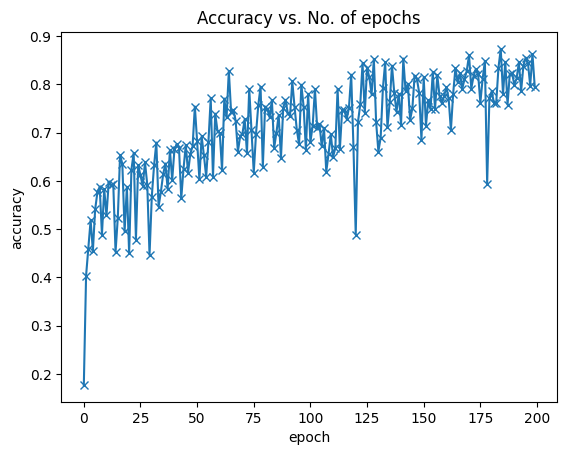

In [14]:
from matplotlib import pyplot as plt

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')


plot_accuracies(history)

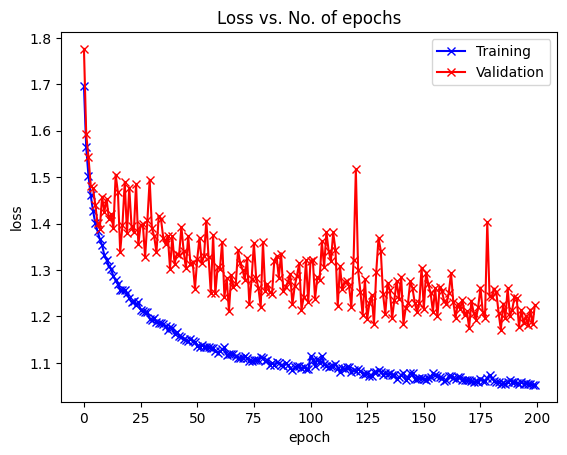

In [15]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')


plot_losses(history)

In [16]:
# 保存模型参数
# torch.save(self.state_dict(), '/kaggle/working/model_weights.pth')
self.save_model()

/kaggle/working/87.33%_model_weights.pth
